In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import matplotlib.pyplot as plt
import numpy as np
import snntorch as snn
import os
import pandas as pd
from TSB_AD.snn.encoders import DynamicReceptiveEncoder
from TSB_AD.snn.activations import DynamicReceptiveSpikeActivation, SpikeActivation, TernarySpikeActivation
from TSB_AD.snn.params import running_params

seed = 2025
torch.manual_seed(seed)
np.random.seed(seed)

In [2]:
src_dir_path = '/home/hwkang/dev-TSB-AD/TSB-AD/Datasets/TSB-AD-M'
#file_name = '130_OPPORTUNITY_id_2_HumanActivity_tr_1045_1st_1145.csv'
file_name = '065_SMD_id_9_Facility_tr_737_1st_837.csv'
file_path = os.path.join(src_dir_path, file_name)

In [3]:
local_running_params = running_params.copy()
local_running_params['batch_size'] = 2
local_running_params['num_enc_features'] = 4
local_running_params['activations']['dynamic_receptive']['adaptation'] = False
local_running_params['activations']['dynamic_receptive']['sensitization'] = False
local_running_params['activations']['dynamic_receptive']['delta_activation'] = True
local_running_params['activations']['dynamic_receptive']['burst'] = True
local_running_params['activations']['dynamic_receptive']['integration'] = 'concat'

In [4]:
window_size = local_running_params['window_size'] = 100

idx_start = 797
idx_end = idx_start + window_size

num_raw_features = 4

In [5]:
real = True

if real:
    df = pd.read_csv(file_path).dropna()
    data = df.iloc[idx_start:idx_end, 0:num_raw_features].values.astype(float)
    label = df['Label'].astype(int).to_numpy()

    zero_pruning = False
    if zero_pruning:
        # zero pruning
        mask = np.any(data != 0, axis=0)
        num_zero = np.sum(~mask)
        if num_zero > 0:
            data = data[:, mask]
        num_raw_features = num_raw_features - num_zero
    
    # repeat data to (B, C, L)
    data = np.repeat(data[np.newaxis, :, :], local_running_params['batch_size'], axis=0)

    # normalize data
    normalize = True
    if normalize:
        data = (data - np.min(data)) / (np.max(data) - np.min(data))
else:
    data = torch.zeros((2, num_raw_features, window_size)) # (B, C, L)

    # (0, 0, L)
    data[0, 0, 10:20] = 1
    data[0, 0, 50:80] = 1

    # (0, 1, L)
    data[0, 1, 10:20] = 1
    data[0, 1, 60:90] = 1

    # (1, 0, L)
    data[1, 0, 30:40] = 1
    data[1, 0, 70:95] = 1

    # (1, 1, L)
    data[1, 1, 40:50] = 1
    data[1, 1, 60:70] = 1    

In [6]:
encoder = DynamicReceptiveEncoder(
    local_running_params=local_running_params,
    num_raw_features=num_raw_features,
)

In [7]:
binary_lif = snn.Leaky(beta=0.9, spike_grad=None, threshold=1.0, init_hidden=True, output=False, reset_mechanism='subtract')

In [8]:
if isinstance(data, np.ndarray):
    data = torch.from_numpy(data).float()
else:
    data = data.permute(0, 2, 1) # (B, L, C)
spk_rec, activations = encoder(data, outputs=True)
relu_activations = F.relu(activations)

In [9]:
print(spk_rec.shape) # (B, E, L)

torch.Size([2, 4, 100])


In [10]:
binary_lif_spk_rec = []
activations = activations.permute(2, 0, 1) # (L, B, E)
for i in range(activations.shape[0]):
    spk = binary_lif(activations[i])
    binary_lif_spk_rec.append(spk)
binary_lif_spk_rec = torch.stack(binary_lif_spk_rec, dim=-1) # (B, E, L)
activations = activations.permute(1, 2, 0) # (B, E, L)

In [11]:
print(binary_lif_spk_rec.shape) # (B, E, L)

torch.Size([2, 4, 100])


In [12]:
def plot_binary():
    if real:
        # find the first index of the label
        first_anomaly_idx = np.where(label[idx_start:idx_end] == 1)[0][0]
        last_anomaly_idx = np.where(label[idx_start:idx_end] == 1)[0][-1]

    num_channels = spk_rec.shape[1]

    fig, axs = plt.subplots(1+1+num_channels, 1, figsize=(10, 12), sharex=True)
    fig.suptitle('Dynamic Receptive Encoding', fontsize=16)

    # 1 Input data (First batch)
    axs[0].set_title('Input data', loc='left', fontsize=11) 
    colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown'] * 10
    #for i in range(num_raw_features):
    axs[0].plot(data[0], label=f'Input')
    if real:
        axs[0].scatter(np.where(label[idx_start:idx_end] == 1)[0], np.ones(np.sum(label[idx_start:idx_end] == 1)), color='black', label='Label', s=4)

    # 2 Activations (First batch)
    for idx in range(num_channels):
        normed_activations = activations[0, idx, :].detach().numpy()
        normed_activations = (normed_activations - np.min(normed_activations)) / (np.max(normed_activations) - np.min(normed_activations))
        axs[1].plot(normed_activations+1.0*idx, label=f'Channel {idx}', color='green')
        axs[1].set_yticks([0, 1, 2, 3, 4])
        axs[1].set_ylim(-0.5, 4.5)
        # horizontal line at every 1.0
        axs[1].axhline(y=1.0*idx, color='black', lw=0.5, ls='--')

    # 3 Spikes (First batch)
    for idx, ax in enumerate(axs[2:]):
        ax.plot(relu_activations[0, idx, :].detach().numpy(), label=f'ReLU', color='green')
        ax.plot(spk_rec[0, idx, :].detach().numpy()+0.1, label=f'Spikes', color='blue')
        ax.plot(binary_lif_spk_rec[0, idx, :].detach().numpy()+0.2, label=f'Binary LIF', color='red')
        
        ax.set_yticks([0, 1, 2, 3])
        ax.set_ylim(-0.5, 3.5)
        ax.set_title(f'Channel {idx+1}', loc='left', fontsize=11)
        #ax.legend(loc='upper left', fontsize=8)

    # Common X-axis
    axs[-1].set_xlabel('Timesteps')

    # draw vertical line at idx_start for all subplots
    if real:
        for ax in axs:
            ax.axvline(x=first_anomaly_idx, color='black', lw=0.5, ls='--')
            ax.axvline(x=last_anomaly_idx, color='black', lw=0.5, ls='--')
        
    plt.tight_layout()
    plt.show()

def plot_ternary():
    pass

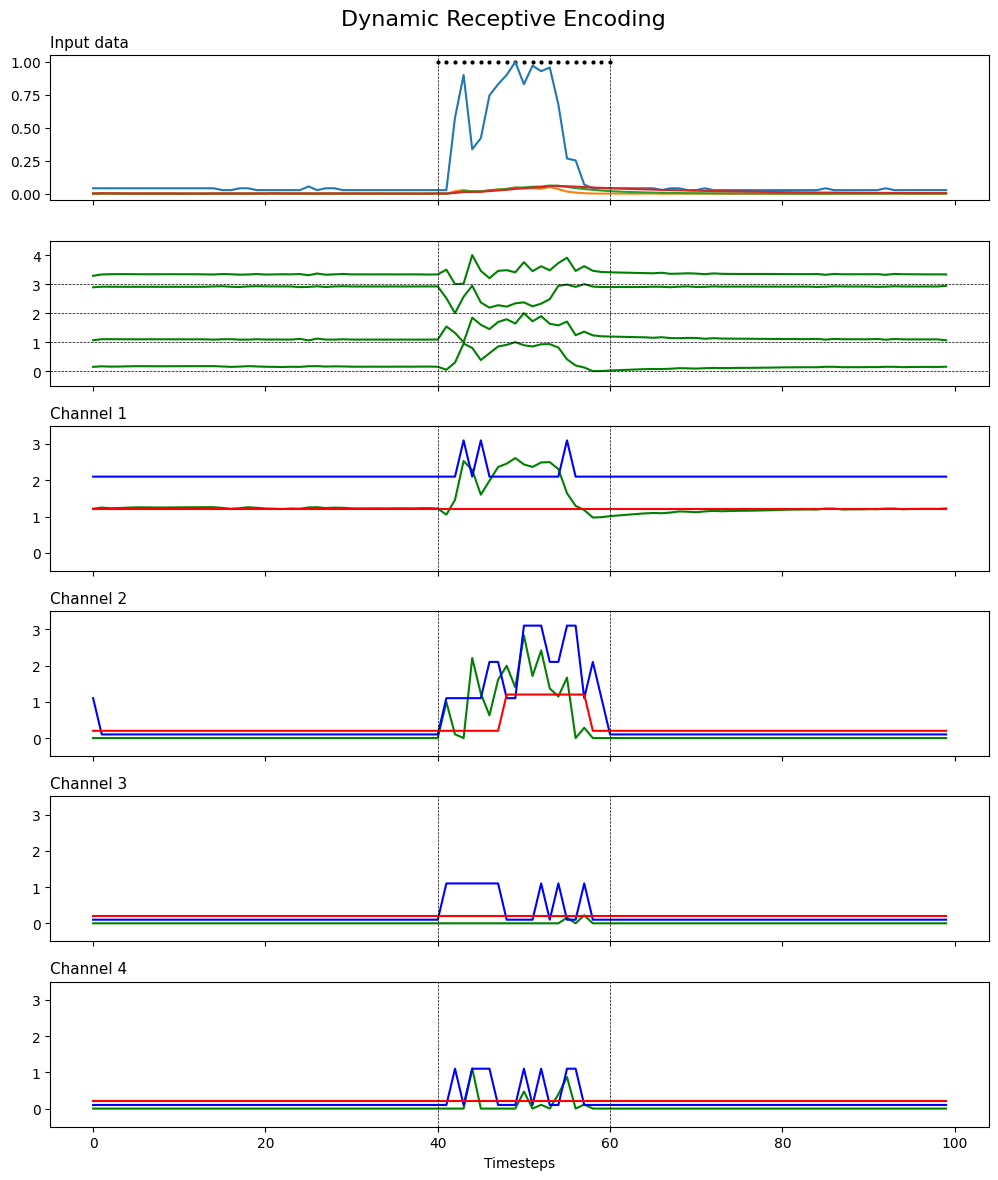

In [13]:
plot_binary()

In [14]:
relu_activations_flat = relu_activations.view(relu_activations.shape[0], -1)
dr_spk_rec_flat = spk_rec.view(spk_rec.shape[0], -1)
binary_lif_spk_rec_flat = binary_lif_spk_rec.view(binary_lif_spk_rec.shape[0], -1)

In [15]:
# MSE between relu_activations and spikes
mse_relu_dr = F.mse_loss(relu_activations_flat, dr_spk_rec_flat)
mse_relu_binary = F.mse_loss(relu_activations_flat, binary_lif_spk_rec_flat)

# MAE
mae_relu_dr = F.l1_loss(relu_activations_flat, dr_spk_rec_flat)
mae_relu_binary = F.l1_loss(relu_activations_flat, binary_lif_spk_rec_flat)

print(f'MSE between ReLU activations and DR spikes: {mse_relu_dr.item()}')
print(f'MSE between ReLU activations and Binary LIF spikes: {mse_relu_binary.item()}\n')

print(f'MAE between ReLU activations and DR spikes: {mae_relu_dr.item()}')
print(f'MAE between ReLU activations and Binary LIF spikes: {mae_relu_binary.item()}\n')

# MSE and MAE between DR spikes and Binary LIF spikes
mse_dr_binary = F.mse_loss(dr_spk_rec_flat, binary_lif_spk_rec_flat)
mae_dr_binary = F.l1_loss(dr_spk_rec_flat, binary_lif_spk_rec_flat)
print(f'MSE between DR spikes and Binary LIF spikes: {mse_dr_binary.item()}')
print(f'MAE between DR spikes and Binary LIF spikes: {mae_dr_binary.item()}')

MSE between ReLU activations and DR spikes: 0.2605227530002594
MSE between ReLU activations and Binary LIF spikes: 0.12038949877023697

MAE between ReLU activations and DR spikes: 0.2803758382797241
MAE between ReLU activations and Binary LIF spikes: 0.13049858808517456

MSE between DR spikes and Binary LIF spikes: 0.41999998688697815
MAE between DR spikes and Binary LIF spikes: 0.36500000953674316
